In [156]:
# ！pip install functorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import pandas as pd
import scipy
from scipy import stats
import numpy as np
from os import path

In [157]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [158]:
MA_DAYS = 25
trading_days_in_year = 252

# Import raw data from yahoo finance

In [159]:
from google.colab import drive
drive.mount('/content/drive')
data_files_path_prefix = "/content/drive/MyDrive"
data_files_path = "ML-Portfolio-Data"
data_files_path = path.join(data_files_path_prefix, data_files_path)

high_risk_file = 'SPY.csv'
low_risk_file = 'O9P.SI.csv'
high_risk = pd.read_csv(path.join(data_files_path, high_risk_file))
low_risk = pd.read_csv(path.join(data_files_path, low_risk_file))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
# Read files from the same directory
#high_risk = pd.read_csv('SPY.csv')
#low_risk = pd.read_csv('O9P.SI.csv')

In [161]:
high_risk = high_risk[:1008]
low_risk = low_risk[:1008]
print(high_risk.shape)
print(low_risk.shape)

(1008, 7)
(1008, 7)


In [162]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-28,245.169998,245.199997,244.089996,244.570007,224.240860,40565600
1,2017-08-29,243.059998,245.149994,242.929993,244.850006,224.497574,51135700
2,2017-08-30,244.830002,246.320007,244.619995,246.009995,225.561142,62030800
3,2017-08-31,246.720001,247.770004,246.050003,247.490005,226.918106,103803900
4,2017-09-01,247.919998,248.330002,247.669998,247.839996,227.239059,62007000


In [163]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-28,10.90,10.90,10.88,10.88,10.88,7400
1,2017-08-29,10.89,10.90,10.89,10.90,10.90,1400
2,2017-08-30,10.94,10.94,10.94,10.94,10.94,5300
3,2017-08-31,10.92,10.96,10.92,10.93,10.93,30700
4,2017-09-04,10.89,10.89,10.80,10.83,10.83,59800


# ML Portfolio

## Enrich data

### Calculate daily returns

In [164]:
def add_daily_return(market_data):
    market_data["Daily Return"]  = market_data['Close'] - market_data['Open']

add_daily_return(high_risk)
add_daily_return(low_risk)

### Calculate moving average (MA) of daily returns

In [165]:
def add_moving_average(market_data, ma_days):
    temp_vars = []

    # df = market_data
    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data[temp_var] = market_data["Daily Return"].shift(i)
        temp_vars.append(temp_var)

    market_data["MA"] = market_data[temp_vars].mean(axis=1)

    for i in range(0,ma_days):
        temp_var = "M_{0}".format(i)
        market_data.drop(temp_var, axis = 1, inplace = True)

add_moving_average(high_risk, MA_DAYS)
add_moving_average(low_risk, MA_DAYS)


In [166]:
high_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
1003,2021-08-23,445.160004,448.230011,443.440002,447.260010,440.990021,54973000,2.100006,0.880400
1004,2021-08-24,447.970001,448.540009,447.420013,447.970001,441.690033,38744700,0.000000,0.665200
1005,2021-08-25,448.170013,449.459991,447.769989,448.910004,442.616913,40529700,0.739991,0.606400
1006,2021-08-26,448.609985,448.859985,446.160004,446.260010,440.004089,57829600,-2.349975,0.483601
1007,2021-08-27,447.119995,450.649994,447.059998,450.250000,443.938110,77235100,3.130005,0.512001


In [167]:
low_risk.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA
1003,2021-08-24,9.83,9.86,9.81,9.84,9.84,19960,0.01,-0.0316
1004,2021-08-25,9.90,9.90,9.85,9.86,9.86,102205,-0.04,-0.0320
1005,2021-08-26,9.89,9.89,9.86,9.86,9.86,66520,-0.03,-0.0296
1006,2021-08-27,9.90,9.90,9.86,9.88,9.88,68015,-0.02,-0.0308
1007,2021-08-30,9.79,9.79,9.77,9.78,9.78,1017465,-0.01,-0.0312


### Calculate ROE

In [168]:
def add_roe(market_data):    
    market_data["Prev Close"] = market_data["Close"].shift(1)
    market_data["ROE"] = (market_data["Close"] - market_data["Prev Close"]) / market_data['Prev Close']

add_roe(high_risk)
add_roe(low_risk)

In [169]:
def add_roe_binary(market_data, tau=-0.005):    
    market_data["ROE Binary"] = np.where(market_data["ROE"].values < tau, 0, 1)

add_roe_binary(high_risk)
add_roe_binary(low_risk)

In [170]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2017-08-28,245.169998,245.199997,244.089996,244.570007,224.240860,40565600,-0.599991,-0.599991,NaN,NaN,1
1,2017-08-29,243.059998,245.149994,242.929993,244.850006,224.497574,51135700,1.790008,0.595009,244.570007,0.001145,1
2,2017-08-30,244.830002,246.320007,244.619995,246.009995,225.561142,62030800,1.179993,0.790003,244.850006,0.004738,1
3,2017-08-31,246.720001,247.770004,246.050003,247.490005,226.918106,103803900,0.770004,0.785004,246.009995,0.006016,1
4,2017-09-01,247.919998,248.330002,247.669998,247.839996,227.239059,62007000,-0.080002,0.612002,247.490005,0.001414,1


In [171]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
0,2017-08-28,10.90,10.90,10.88,10.88,10.88,7400,-0.02,-0.020000,NaN,NaN,1
1,2017-08-29,10.89,10.90,10.89,10.90,10.90,1400,0.01,-0.005000,10.88,0.001838,1
2,2017-08-30,10.94,10.94,10.94,10.94,10.94,5300,0.00,-0.003333,10.90,0.003670,1
3,2017-08-31,10.92,10.96,10.92,10.93,10.93,30700,0.01,0.000000,10.94,-0.000914,1
4,2017-09-04,10.89,10.89,10.80,10.83,10.83,59800,-0.06,-0.012000,10.93,-0.009149,0


## Build feature space

In [172]:
def remove_for_ma(market_data, ma_days):
  return market_data[ma_days:]

high_risk = remove_for_ma(high_risk, MA_DAYS)
low_risk = remove_for_ma(low_risk, MA_DAYS)

In [173]:
print(high_risk.shape)

(983, 12)


In [174]:
def standardize_columns(market_data, columns):
  for column in columns:
    market_data[column] = market_data[column]/market_data[column].std()

standardize_columns(high_risk, ['Volume', 'Daily Return', 'MA'])
standardize_columns(low_risk, ['Volume', 'Daily Return', 'MA'])

<ipython-input-174-d0986728a5f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data[column] = market_data[column]/market_data[column].std()


In [175]:
high_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2017-10-03,252.320007,252.889999,252.229996,252.860001,232.992355,1.367891,0.208144,0.708710,252.320007,0.002140,1
26,2017-10-04,252.690002,253.440002,252.559998,253.160004,233.268799,1.145610,0.181166,0.583476,252.860001,0.001186,1
27,2017-10-05,253.539993,254.679993,253.199997,254.660004,234.650909,1.300584,0.431716,0.577785,253.160004,0.005925,1
28,2017-10-06,254.149994,254.699997,253.850006,254.369995,234.383713,1.651169,0.084801,0.525604,254.660004,-0.001139,1
29,2017-10-09,254.630005,254.699997,253.649994,253.949997,233.996689,0.733043,-0.262114,0.468679,254.369995,-0.001651,1


In [176]:
low_risk.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary
25,2017-10-03,10.86,10.87,10.86,10.86,10.86,0.659605,0.000000,-0.383962,10.85,0.000922,1
26,2017-10-04,10.86,10.86,10.86,10.86,10.86,0.000000,0.000000,-0.393561,10.86,0.000000,1
27,2017-10-05,10.89,10.89,10.88,10.88,10.88,0.172782,-0.045821,-0.403161,10.86,0.001842,1
28,2017-10-06,10.89,10.89,10.87,10.88,10.88,0.371247,-0.045821,-0.422359,10.88,0.000000,1
29,2017-10-09,10.88,10.88,10.85,10.88,10.88,0.254503,0.000000,-0.364764,10.88,0.000000,1


In [177]:
def to_X_train_features(low_risk, high_risk):
  high_risk_train = high_risk[:1000]
  low_risk_train = low_risk[:1000]
  return np.vstack((high_risk_train['Daily Return'], high_risk_train['MA'], high_risk_train['Volume'], low_risk_train['Daily Return'], low_risk_train['MA'], low_risk_train['Volume']))

X = to_X_train_features(low_risk, high_risk).T
print(X.shape, X)

(983, 6) [[ 0.20814449  0.7087102   1.36789127  0.         -0.38396238  0.65960516]
 [ 0.18116558  0.58347574  1.14561011  0.         -0.39356144  0.        ]
 [ 0.43171613  0.57778499  1.30058409 -0.04582138 -0.4031605   0.17278153]
 ...
 [ 0.28523475  1.43829291  0.82981674 -0.13746413 -0.71033041  0.77658292]
 [-0.90581443  1.1470315   1.18401988 -0.09164275 -0.73912759  0.79403619]
 [ 1.20648249  1.2143914   1.58133367 -0.04582138 -0.74872665 11.87832143]]


In [178]:
def to_Y_train_features(low_risk, high_risk):
  high_risk_train = high_risk[0:1000]
  return high_risk_train['ROE Binary'].values

Y = to_Y_train_features(low_risk, high_risk)
print(Y.shape, Y)

(983,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0
 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0
 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1

## Build graph

In [179]:
X_tensor = torch.from_numpy(X)
print(type(X), X.shape, X_tensor.size())
Y_tensor = torch.from_numpy(Y).double()
print(type(Y), Y.shape, Y_tensor.size())

<class 'numpy.ndarray'> (983, 6) torch.Size([983, 6])
<class 'numpy.ndarray'> (983,) torch.Size([983])


In [180]:
a = torch.randn((6), requires_grad=True, dtype=torch.double)
b = torch.randn((6), requires_grad=True, dtype=torch.double)
print(a, a.size(), b, b.size())

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863],
       dtype=torch.float64, requires_grad=True) torch.Size([6]) tensor([ 2.2082, -0.6380,  0.4617,  0.2674,  0.5349,  0.8094],
       dtype=torch.float64, requires_grad=True) torch.Size([6])


In [181]:
lr = 1e-1
n_epochs = 500
torch.manual_seed(42)
lambda1 = 1e-3 #0.5
lambda2 = 1e-3 #0.5

loss_fn = nn.BCELoss()
optimizer = optim.SGD([a, b], lr=lr)

In [182]:
for epoch in range(n_epochs):
  
    yhat = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))

    loss = loss_fn(yhat, Y_tensor)
    loss.backward()   

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}. Loss: {loss}")

    optimizer.step()
    optimizer.zero_grad()
    
print(a, b)

Epoch: 0. Loss: 1.6054652614575213
Epoch: 10. Loss: 1.0183867082015365
Epoch: 20. Loss: 0.7591680940235691
Epoch: 30. Loss: 0.6226023509902733
Epoch: 40. Loss: 0.5505343655289575
Epoch: 50. Loss: 0.5093908197922075
Epoch: 60. Loss: 0.4830485343127667
Epoch: 70. Loss: 0.46456857554768866
Epoch: 80. Loss: 0.4507339928349276
Epoch: 90. Loss: 0.4398778751354717
Epoch: 100. Loss: 0.43105877059182807
Epoch: 110. Loss: 0.42371846587690537
Epoch: 120. Loss: 0.41752186864734364
Epoch: 130. Loss: 0.41227177780214364
Epoch: 140. Loss: 0.4078548240241467
Epoch: 150. Loss: 0.40419938491953233
Epoch: 160. Loss: 0.40124143513628946
Epoch: 170. Loss: 0.39890377112859776
Epoch: 180. Loss: 0.397092673388223
Epoch: 190. Loss: 0.39570726182221816
Epoch: 200. Loss: 0.3946519134866871
Epoch: 210. Loss: 0.3938448707188545
Epoch: 220. Loss: 0.39322136787868944
Epoch: 230. Loss: 0.3927327455435187
Epoch: 240. Loss: 0.39234365459634696
Epoch: 250. Loss: 0.3920288709963018
Epoch: 260. Loss: 0.3917704881043878
Ep

## Build efficient frontier

In [183]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(X_tensor, a)) / (torch.exp (torch.matmul(X_tensor, a)) + torch.exp(torch.matmul(X_tensor, b)))
  print(y_test)

tensor([8.8712e-01, 8.1880e-01, 9.0748e-01, 8.5849e-01, 5.6139e-01, 7.2338e-01,
        8.0662e-01, 7.3600e-01, 7.3141e-01, 7.2886e-01, 8.8288e-01, 6.5808e-01,
        8.8021e-01, 8.7035e-01, 4.8500e-01, 7.8670e-01, 7.2756e-01, 6.9909e-01,
        9.3119e-01, 7.7524e-01, 7.3233e-01, 6.1997e-01, 7.6104e-01, 8.3839e-01,
        8.0030e-01, 6.9464e-01, 8.0230e-01, 8.8116e-01, 7.9602e-01, 8.6394e-01,
        8.0019e-01, 7.6406e-01, 8.9713e-01, 7.4368e-01, 8.6668e-01, 8.9198e-01,
        6.8396e-01, 6.4273e-01, 6.8025e-01, 9.7345e-01, 7.4561e-01, 9.6656e-01,
        9.2522e-01, 4.2230e-01, 8.1441e-01, 7.7693e-01, 7.9186e-01, 8.5078e-01,
        8.0616e-01, 7.4720e-01, 8.0461e-01, 5.6717e-01, 9.6328e-01, 8.0603e-01,
        4.9914e-01, 5.2728e-01, 7.2558e-01, 7.3123e-01, 6.7932e-01, 6.7926e-01,
        6.8114e-01, 4.7929e-01, 9.0989e-01, 9.3556e-01, 8.3747e-01, 9.0838e-01,
        7.9554e-01, 7.2597e-01, 8.1966e-01, 9.1210e-01, 9.4476e-01, 3.8257e-01,
        9.6539e-01, 7.8732e-01, 9.4549e-

### Build ML Portfolio

In [184]:
prob = pd.DataFrame(y_test).astype("float")
display(prob)
rolling_prob = prob.rolling(25).mean().iloc[-1]
display(rolling_prob.to_numpy()[0])

,0
0,0.887115
1,0.818803
2,0.907484
3,0.858486
4,0.561395
...,...
978,0.973960
979,0.855042
980,0.901969
981,0.404727


0.8661619865461084

In [185]:
def calculate_ml_portfolio_weights(x, k):
  return 0 if x < k else 1

for k in np.arange(0, 1, 0.1):
  print(calculate_ml_portfolio_weights(rolling_prob.to_numpy()[0], k))

1
1
1
1
1
1
1
1
1
0


In [186]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)
# vfunc(x)
# calculate_ml_portfolio_weights = functorch.vmap(ml_portfolio_weights, out_dims=1)
# forecast = 
# portfolio_weights = calculate_ml_portfolio_weights(y_test.numpy())
# print(portfolio_weights)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 

In [187]:
Xt = torch.from_numpy(to_X_train_features(low_risk, high_risk).T[-1])
Xt

tensor([ 1.2065,  1.2144,  1.5813, -0.0458, -0.7487, 11.8783],
       dtype=torch.float64)

In [188]:
with torch.no_grad():
  y_test = torch.exp(torch.matmul(Xt, a)) / (torch.exp (torch.matmul(Xt, a)) + torch.exp(torch.matmul(Xt, b)))
  print(y_test)

tensor(0.9999, dtype=torch.float64)


In [189]:
k = 0.5
calculate_ml_portfolio_weights_lambda = lambda x: 0 if x < k else 1
calculate_ml_portfolio_weights = np.vectorize(calculate_ml_portfolio_weights_lambda)

portfolio_weights = y_test.apply_(calculate_ml_portfolio_weights_lambda)
print(portfolio_weights)

tensor(1., dtype=torch.float64)


# MV Portfolio

In [190]:
def add_daily_return(market_data):
    market_data["Pct Return"]  = market_data['Close'].pct_change()

add_daily_return(high_risk)
add_daily_return(low_risk)

In [191]:
high_risk

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA,Prev Close,ROE,ROE Binary,Pct Return
25,2017-10-03,252.320007,252.889999,252.229996,252.860001,232.992355,1.367891,0.208144,0.708710,252.320007,0.002140,1,NaN
26,2017-10-04,252.690002,253.440002,252.559998,253.160004,233.268799,1.145610,0.181166,0.583476,252.860001,0.001186,1,0.001186
27,2017-10-05,253.539993,254.679993,253.199997,254.660004,234.650909,1.300584,0.431716,0.577785,253.160004,0.005925,1,0.005925
28,2017-10-06,254.149994,254.699997,253.850006,254.369995,234.383713,1.651169,0.084801,0.525604,254.660004,-0.001139,1,-0.001139
29,2017-10-09,254.630005,254.699997,253.649994,253.949997,233.996689,0.733043,-0.262114,0.468679,254.369995,-0.001651,1,-0.001651
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2021-08-23,445.160004,448.230011,443.440002,447.260010,440.990021,1.125533,0.809462,2.088182,443.359985,0.008797,1,0.008797
1004,2021-08-24,447.970001,448.540009,447.420013,447.970001,441.690033,0.793270,0.000000,1.577758,447.260010,0.001587,1,0.001587
1005,2021-08-25,448.170013,449.459991,447.769989,448.910004,442.616913,0.829817,0.285235,1.438293,447.970001,0.002098,1,0.002098
1006,2021-08-26,448.609985,448.859985,446.160004,446.260010,440.004089,1.184020,-0.905814,1.147032,448.910004,-0.005903,0,-0.005903


In [192]:
high_risk_return_annual = high_risk["Pct Return"].mean() * trading_days_in_year
low_risk_return_annual = low_risk["Pct Return"].mean() * trading_days_in_year
print(high_risk_return_annual)
print(low_risk_return_annual)

0.16991270635336397
-0.018768221949339046


In [193]:
high_risk_var_daily = high_risk["Pct Return"].var()
low_risk_var_daily = low_risk["Pct Return"].var()
print(high_risk_var_daily)
print(low_risk_var_daily)

0.00017197969163255594
6.325232453016195e-05


## Build data for high and low risk

In [194]:
mv_data = pd.DataFrame(data={'high': high_risk['Close'], 'low':low_risk['Close']})
mv_data

,high,low
25,252.860001,10.86
26,253.160004,10.86
27,254.660004,10.88
28,254.369995,10.88
29,253.949997,10.88
...,...,...
1003,447.260010,9.84
1004,447.970001,9.86
1005,448.910004,9.86
1006,446.260010,9.88


In [195]:
def get_annual_sample_return_and_covariance(data):
    daily_return = data.pct_change()
    annual_return = daily_return.mean() * trading_days_in_year
    # daily_covariance = data.cov()
    daily_covariance = daily_return.cov()
    annual_covariance = daily_covariance * trading_days_in_year
    return annual_return, annual_covariance

In [196]:
r, cov = get_annual_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.169913
low    -0.018768
dtype: float64

,high,low
high,0.043339,0.002438
low,0.002438,0.015940


In [197]:
def get_sample_return_and_covariance(data):
    daily_return = data.pct_change().mean()
    daily_covariance = data.pct_change().cov()
    return daily_return, daily_covariance

In [215]:
r, cov = get_sample_return_and_covariance(mv_data)
display(r)
display(cov)

high    0.000674
low    -0.000074
dtype: float64

,high,low
high,0.000172,0.000010
low,0.000010,0.000063


## Optimization using linear programming

(Reference: https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios)


In [260]:
TERMINATION = 10**-9

In [261]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
    #dependencies
    from scipy.optimize import linprog
    import numpy as np
    
    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1] 
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
    return res

In [262]:
#function obtains minimal risk portfolio 

from scipy import optimize 

def MinimizeRisk(CovarReturns, PortfolioSize):
    
    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T) 
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    
    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = TERMINATION)
    
    return opt

In [263]:
def print_min_variance_portfolio(mean_returns, cov_returns):
    number_of_assets = len(mean_returns)
    result = MinimizeRisk(cov_returns, number_of_assets)

    print()
    minRiskWeights = result.x
    minRiskExpPortfolioReturn = np.matmul(mean_returns.T, minRiskWeights)
    print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)
    minRisk = np.matmul(np.matmul(minRiskWeights, cov_returns), minRiskWeights.T) 
    print("Variance of Minimum Risk Portfolio : %7.6f" % minRisk)
    print("S.D. of Minimum Risk Portfolio : %7.6f" % np.sqrt(minRisk))
    threshold = 1e-3
    print("Weights (showing only those > %.6f): " % threshold)
    for i in range(0, number_of_assets):
        if result.x[i] > threshold:
            print(f"{mean_returns.index[i]}\t{result.x[i]:.6f}")
    print('Assets Considered:')
    print(mean_returns.index.to_numpy())

In [264]:
#function obtains Minimal risk and Maximum return portfolios

#dependencies
import numpy as np
from scipy import optimize 

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
    def  f(x,CovarReturns):
         
        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq 
        return EqconstraintVal
    
    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal
    

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = TERMINATION)
    
    return  opt

In [265]:
print_min_variance_portfolio(r, cov)


Expected Return of Minimum Risk Portfolio:  0.000111
Variance of Minimum Risk Portfolio : 0.000050
S.D. of Minimum Risk Portfolio : 0.007068
Weights (showing only those > 0.001000): 
high	0.248181
low	0.751819
Assets Considered:
['high' 'low']


In [266]:
#Maximal expected portfolio return computation for the k-portfolio
result1 = MaximizeReturns(r, 2)
maxReturnWeights = result1.x
maxExpPortfolioReturn = np.matmul(r.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.6f" % maxExpPortfolioReturn )

Maximal Expected Portfolio Return:   0.000674


In [267]:
#expected portfolio return computation for the minimum risk k-portfolio 
result2 = MinimizeRisk(cov, 2)
minRiskWeights = result2.x
minRiskExpPortfolioReturn = np.matmul(r.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.6f" % minRiskExpPortfolioReturn)

Expected Return of Minimum Risk Portfolio:  0.000111


In [278]:
#compute efficient set for the maximum return and minimum risk portfolios
increment = 0.000001
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set 
while (low < high):
    
    result3 = MinimizeRiskConstr(r, cov, 2, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment
    
#gather optimal weight set    
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios 
#for trading days = 251
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,cov)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*trading_days_in_year) 

#obtain expected portfolio annualized return for the 
#efficient set portfolios, for trading days = 251
retPoint = trading_days_in_year*np.array(expPortfolioReturnPoint) 

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Size of the  efficient set: (563, 2)
Optimal weights of the efficient set portfolios: 
 [[2.60314002e-01 7.39685998e-01]
 [2.60980100e-01 7.39019900e-01]
 [2.61679259e-01 7.38320741e-01]
 ...
 [9.96115759e-01 3.88424067e-03]
 [9.97867902e-01 2.13209757e-03]
 [9.99003136e-01 9.96863654e-04]]
Annualized Risk and Return of the efficient set portfolios: 
 [[0.11223511 0.02805881]
 [0.11223913 0.02831081]
 [0.11224359 0.02856281]
 ...
 [0.20741737 0.16917881]
 [0.20776121 0.16943081]
 [0.20798411 0.16968281]]


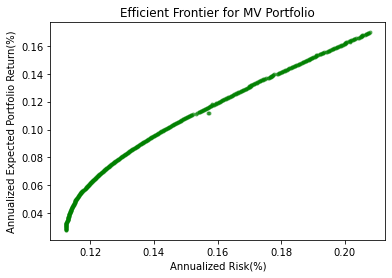

In [279]:
#Graph Efficient Frontier
import matplotlib.pyplot as plt

NoPoints = riskPoint.size

colours = "green"
area = np.pi*3

plt.title('Efficient Frontier for MV Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(riskPoint, retPoint, s=area, c=colours, alpha =0.5)
plt.show()

# Naive Portfolio

In [280]:
naive_risks = []
naive_returns = []

for x in np.arange(0, 1, 0.01):
  weights = [x, 1-x]
  risk = np.matmul((np.matmul(weights,cov)),np.transpose(weights)) * trading_days_in_year
  naive_risks.append(np.sqrt(risk))

  #obtain expected portfolio annualized return for the 
  #efficient set portfolios, for trading days = 251
  ret = trading_days_in_year*(np.matmul(weights,r))
  naive_returns.append(ret)

#display efficient set portfolio parameters
# print("Size of the  efficient set:", xOptimalArray.shape )
# print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[naive_risks, naive_returns])

Annualized Risk and Return of the efficient set portfolios: 
 [[ 1.26252072e-01 -1.87682219e-02]
 [ 1.25199806e-01 -1.68814127e-02]
 [ 1.24182436e-01 -1.49946034e-02]
 [ 1.23200828e-01 -1.31077941e-02]
 [ 1.22255844e-01 -1.12209848e-02]
 [ 1.21348338e-01 -9.33417553e-03]
 [ 1.20479157e-01 -7.44736625e-03]
 [ 1.19649138e-01 -5.56055697e-03]
 [ 1.18859100e-01 -3.67374769e-03]
 [ 1.18109846e-01 -1.78693840e-03]
 [ 1.17402156e-01  9.98708809e-05]
 [ 1.16736786e-01  1.98668016e-03]
 [ 1.16114464e-01  3.87348945e-03]
 [ 1.15535886e-01  5.76029873e-03]
 [ 1.15001712e-01  7.64710801e-03]
 [ 1.14512563e-01  9.53391730e-03]
 [ 1.14069018e-01  1.14207266e-02]
 [ 1.13671612e-01  1.33075359e-02]
 [ 1.13320829e-01  1.51943451e-02]
 [ 1.13017104e-01  1.70811544e-02]
 [ 1.12760817e-01  1.89679637e-02]
 [ 1.12552292e-01  2.08547730e-02]
 [ 1.12391796e-01  2.27415823e-02]
 [ 1.12279533e-01  2.46283916e-02]
 [ 1.12215648e-01  2.65152008e-02]
 [ 1.12200225e-01  2.84020101e-02]
 [ 1.12233284e-01  3.0288819

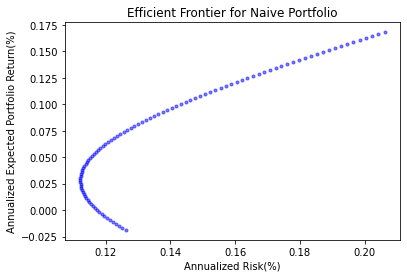

In [281]:
NoPoints = len(naive_risks)

colours = "blue"
area = np.pi*3

plt.title('Efficient Frontier for Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
plt.scatter(naive_risks, naive_returns, s=area, c=colours, alpha =0.5)
plt.show()

# Combined Graph

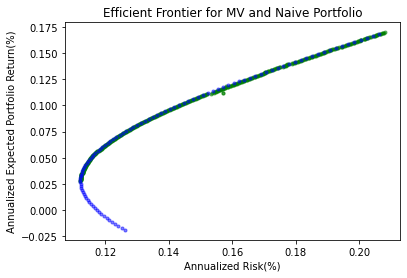

In [282]:
NoPoints = riskPoint.size

colours = "blue"
area = np.pi*3


fig = plt.figure()
ax1 = fig.add_subplot(111)

plt.title('Efficient Frontier for MV and Naive Portfolio')
plt.xlabel('Annualized Risk(%)')
plt.ylabel('Annualized Expected Portfolio Return(%)' )
ax1.scatter(riskPoint, retPoint, s=area, c="green", alpha =0.5)
ax1.scatter(naive_risks, naive_returns, s=area, c="blue", alpha =0.5)
# plt.xlim(riskPoint.min(), riskPoint.max())
plt.show()

In [273]:
cov

,high,low
high,0.000172,0.000010
low,0.000010,0.000063


In [274]:
print(high_risk["Close"].var())
print(high_risk["Close"].var() * trading_days_in_year)
print(high_risk["Close"].pct_change().var())
print(high_risk["Close"].pct_change().var() * trading_days_in_year)
print(np.sqrt(high_risk["Close"].pct_change().var() * trading_days_in_year))

2746.94868824855
692231.0694386346
0.00017197969163255594
0.0433388822914041
0.20817992768613428
